<a href="https://colab.research.google.com/github/dharmesh-data/Capstone_NYC_Taxi_TRip/blob/main/Dc_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [4]:
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/Supervised ML Regression/NYC taxi trip time prediction/Copy of NYC Taxi Data.csv")

In [7]:
df.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

In [8]:
df.shape

(1458644, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


We have id, pickup_datetime, dropoff_datetime, and store_and_fwd_flag of the type ‘object’. vendor_id, passenger_count, and trip_duration are of type int. pickup_longitude, pickup_latitude, dropoff_longitude, and dropoff_latitude are of type float.bold text

In [10]:
df.describe()

vendor_id  passenger_count  ...  dropoff_latitude  trip_duration
count  1.458644e+06     1.458644e+06  ...      1.458644e+06   1.458644e+06
mean   1.534950e+00     1.664530e+00  ...      4.075180e+01   9.594923e+02
std    4.987772e-01     1.314242e+00  ...      3.589056e-02   5.237432e+03
min    1.000000e+00     0.000000e+00  ...      3.218114e+01   1.000000e+00
25%    1.000000e+00     1.000000e+00  ...      4.073588e+01   3.970000e+02
50%    2.000000e+00     1.000000e+00  ...      4.075452e+01   6.620000e+02
75%    2.000000e+00     2.000000e+00  ...      4.076981e+01   1.075000e+03
max    2.000000e+00     9.000000e+00  ...      4.392103e+01   3.526282e+06

[8 rows x 7 columns]

In [11]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [12]:
df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

1. We see that id has 1458644 unique values which are equal to the number of rows in our dataset.
2. There are 2 unique vendor ids.
3. There are 9 unique passenger counts.
4. There are 2 unique values for store_and_fwd_flag, that we also saw in the description of the variables, which are Y and N.

###**Feature Selection**
1. Day hour
2. distance
3. Weekday
4. Month
5. morning, evening 
6. passenger count ( less impact)
7. pickup and dropoff location
8. speed

Remember pickup_datetime and dropoff_datetime were both of type object.we'll convert it to datetime object so that we get some information out of it.

In [13]:
#Converting datetime format to fetch the other details
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


##Now, let us extract and create new features from this datetime features we just created.

In [15]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

contain the information about the name of the day on which ride was taken.

In [16]:
df['pickup_day_no']=df['pickup_datetime'].dt.weekday
df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday

contain the day number like monday=0 and tuesday = 1

In [17]:
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour

contain day in 24 hours format

In [18]:
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

Next, I have defined a function that lets us determine what time of the day the ride was taken. I have created 4 time zones ‘Morning’ (from 6:00 am to 11:59 pm), ‘Afternoon’ (from 12 noon to 3:59 pm), ‘Evening’ (from 4:00 pm to 9:59 pm), and ‘Late Night’ (from 10:00 pm to 5:59 am)

In [19]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [20]:
df['pickup_timeof_day'] = df['pickup_hour'].apply(time_of_day)
df['dropoff_timeof_day'] = df['dropoff_hour'].apply(time_of_day)

In [21]:
from geopy.distance import great_circle

In [22]:
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [23]:
df['distance'] = df.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis=1)

In [24]:
df.head()

id  vendor_id  ... dropoff_timeof_day  distance
0  id2875421          2  ...            Evening  1.498523
1  id2377394          1  ...         Late night  1.805510
2  id3858529          2  ...          Afternoon  6.385108
3  id3504673          2  ...            Evening  1.485501
4  id2181028          2  ...          Afternoon  1.188590

[5 rows x 22 columns]

In [25]:
df.describe()

vendor_id  passenger_count  ...  dropoff_month      distance
count  1.458644e+06     1.458644e+06  ...   1.458644e+06  1.458644e+06
mean   1.534950e+00     1.664530e+00  ...   3.517178e+00  3.440869e+00
std    4.987772e-01     1.314242e+00  ...   1.681217e+00  4.296544e+00
min    1.000000e+00     0.000000e+00  ...   1.000000e+00  0.000000e+00
25%    1.000000e+00     1.000000e+00  ...   2.000000e+00  1.231838e+00
50%    2.000000e+00     1.000000e+00  ...   4.000000e+00  2.093720e+00
75%    2.000000e+00     2.000000e+00  ...   5.000000e+00  3.875343e+00
max    2.000000e+00     9.000000e+00  ...   7.000000e+00  1.240910e+03

[8 rows x 14 columns]

1. Minimum value of distance is quite low
2. Max value is far away from the rest of the values
3. we have to remove these value from the data

###Univariate Analysis

The univariate analysis involves studying patterns of all variables individually.

**Target Variable**

Let us start by analyzing the target variable.

TRip duration

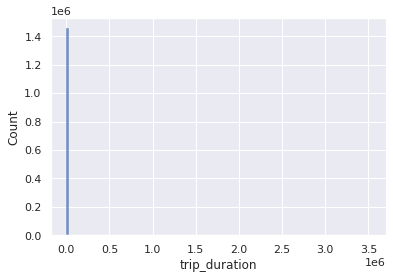

In [26]:
sns.histplot(df['trip_duration'],kde=False,bins=100)

The histogram is right skewed. let's look at the box plot

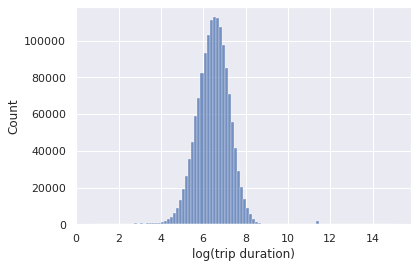

In [27]:
sns.histplot(np.log(df['trip_duration']+1),kde=False,bins=100)
plt.xlabel('log(trip duration)')
plt.show()

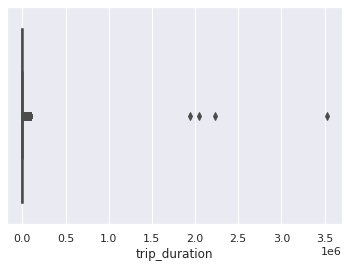

In [28]:
sns.boxplot(df['trip_duration'])

here we can see that total four outliers are there

In [29]:
df['trip_duration'].sort_values(ascending=False)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
1034341          1
346102           1
1360664          1
1382872          1
207497           1
Name: trip_duration, Length: 1458644, dtype: int64

Now, drop the outliers from dataset

In [30]:
df.drop(df[df['trip_duration']== 3526282].index, inplace=True)
df.drop(df[df['trip_duration']== 2227612].index, inplace=True)
df.drop(df[df['trip_duration']== 2049578].index, inplace=True)
df.drop(df[df['trip_duration']== 1939736].index, inplace=True)


In [31]:
df = df[df['trip_duration']>120]

In [32]:
df['passenger_count'].value_counts()

1    1011957
2     207050
5      76786
3      59032
6      47497
4      27985
0         14
9          1
Name: passenger_count, dtype: int64

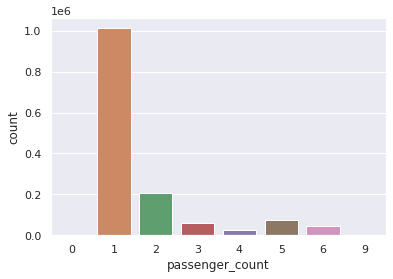

In [33]:
sns.countplot(x='passenger_count',data=df)

1. we can see here there are 60 trip even with 0 passenger.
2. with passenger 7,8 and 9 have 3,1 and 1 trip
3. passenger count 1 has highest number of trip.

Now removing passenger count 0,7,8,9

In [34]:
df = df[df['passenger_count'] != 0 ]
df = df[df['passenger_count']<=6 ]

In [35]:
df.passenger_count.value_counts()

1    1011957
2     207050
5      76786
3      59032
6      47497
4      27985
Name: passenger_count, dtype: int64

In [36]:
df.store_and_fwd_flag.value_counts()

N    1422485
Y       7822
Name: store_and_fwd_flag, dtype: int64

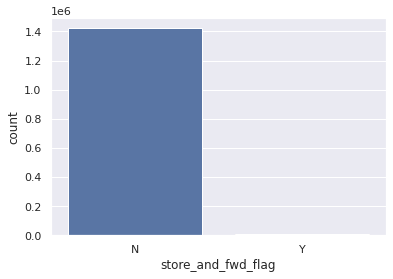

In [37]:
sns.countplot(x='store_and_fwd_flag',data=df)

In [38]:
df.distance.value_counts()

0.000000     3956
0.001273        3
0.001273        2
1.317742        2
1.008660        2
             ... 
1.170960        1
4.757716        1
4.501123        1
10.470789       1
2.543480        1
Name: distance, Length: 1426338, dtype: int64

1. here we can see there are 3961 obs with 0 distance
2. The reasons for 0 km distance can be:

(a)The dropoff location couldn’t be tracked.
(b)The driver deliberately took this ride to complete   atarget ride number.
(c)The passengers canceled the trip.

In [39]:
df = df[df['distance']>0]

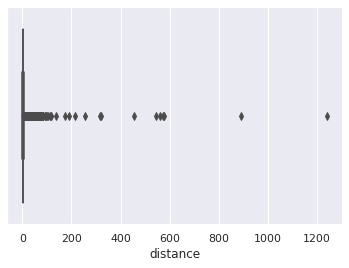

In [40]:
sns.boxplot(df['distance'])

In [41]:
df = df[df['distance']<60]

In [42]:
df = df[df['distance']>0]

In [43]:
df.shape

(1426289, 22)

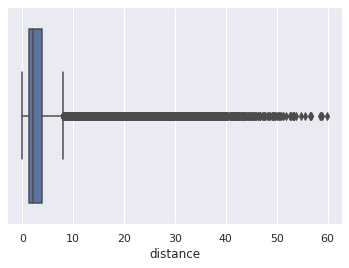

In [44]:
sns.boxplot(df['distance'])

## Trips per day

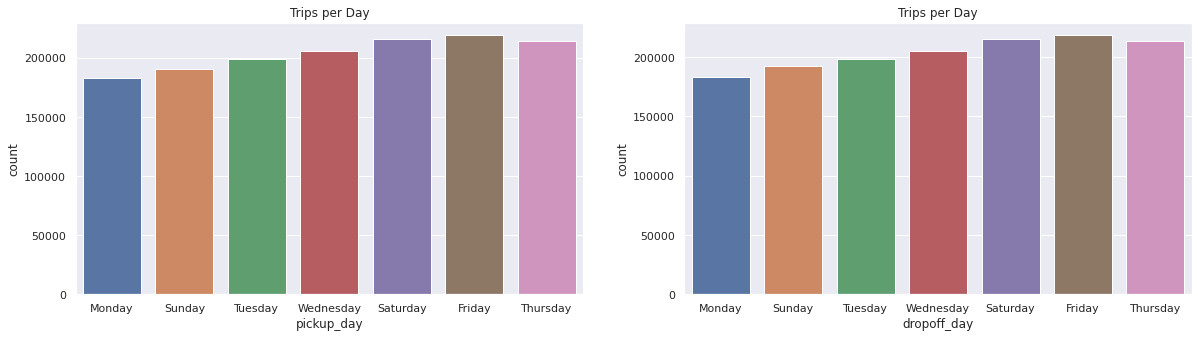

In [45]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Trips per Day')
ax1=sns.countplot(x="pickup_day",data=df,ax=ax1)
ax2.set_title('Trips per Day')
ax2=sns.countplot(x="dropoff_day",data=df,ax=ax2)

here we can see that the fridays are the busiest day followes by saturday because of weekend

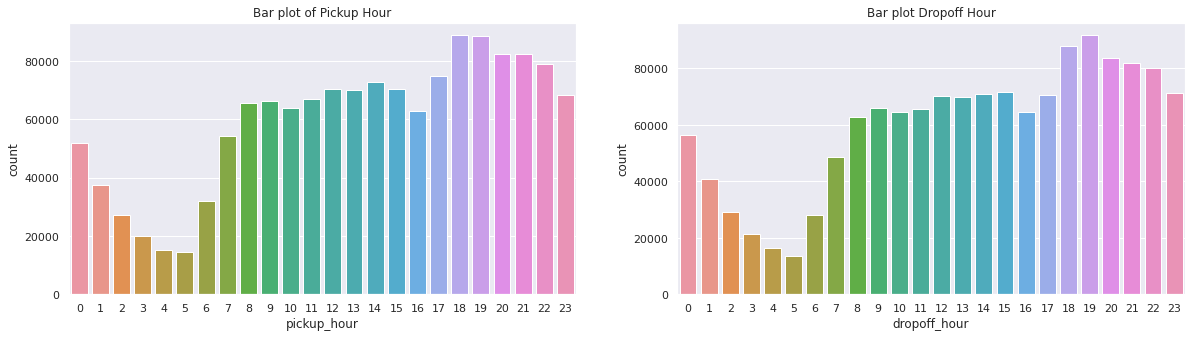

In [46]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Bar plot of Pickup Hour')
ax3=sns.countplot(x='pickup_hour',data=df,ax=ax3)
ax4.set_title('Bar plot Dropoff Hour')
ax4 = sns.countplot(x='dropoff_hour',data=df,ax=ax4)

We see the busiest hours are 6:00 pm to 7:00 pm and that makes sense as this is the time when people return from works.

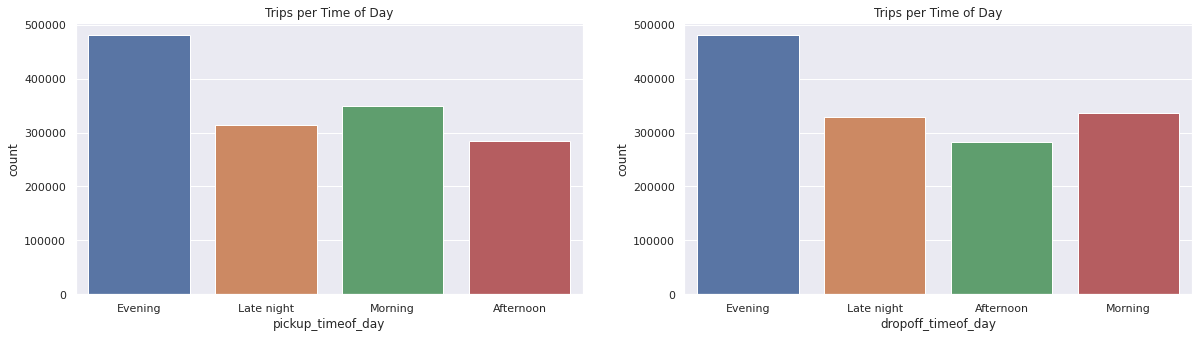

In [47]:
##Trips per Time of Day ( Morning, Afternoon, Evening and Night)
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Trips per Time of Day')
ax1=sns.countplot(x="pickup_timeof_day",data=df,ax=ax1)
ax2.set_title('Trips per Time of Day')
ax2=sns.countplot(x="dropoff_timeof_day",data=df,ax=ax2)

evening is the busiest followed by morning

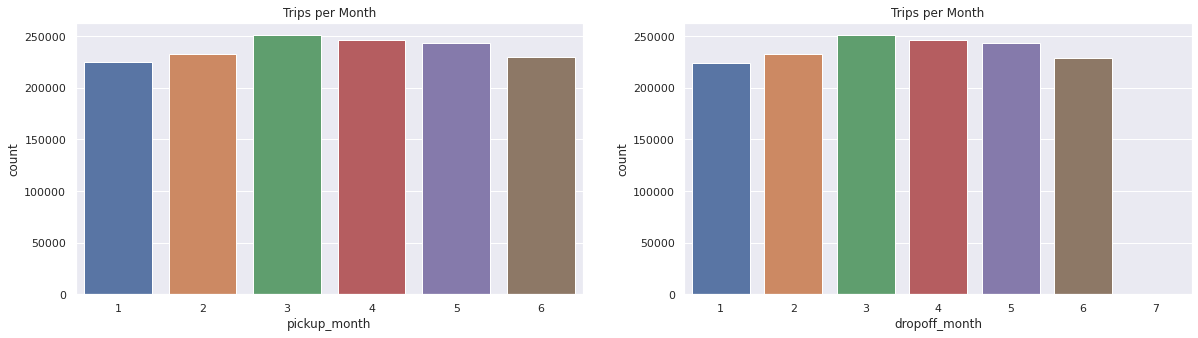

In [48]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Trips per Month')
ax1=sns.countplot(x="pickup_month",data=df,ax=ax1)
ax2.set_title('Trips per Month')
ax2=sns.countplot(x="dropoff_month",data=df,ax=ax2)

march is the busiest

##Bivariate Analysis
Bivariate Analysis involves finding relationships, patterns, and correlations between two variables.

Text(0.5, 1.0, 'Trip Duration per Vendor')

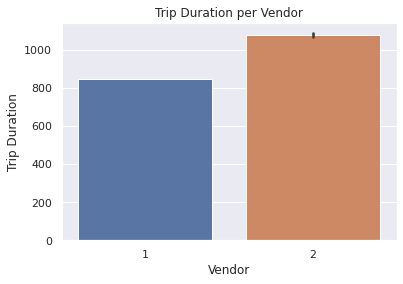

In [49]:
#trips duration per vendor
sns.barplot(y='trip_duration',x='vendor_id',data=df,estimator=np.mean)
plt.ylabel("Trip Duration")
plt.xlabel("Vendor")
plt.title("Trip Duration per Vendor")

vendor id 2 takes longer trips as compare to vendor 1

<Figure size 576x360 with 0 Axes>

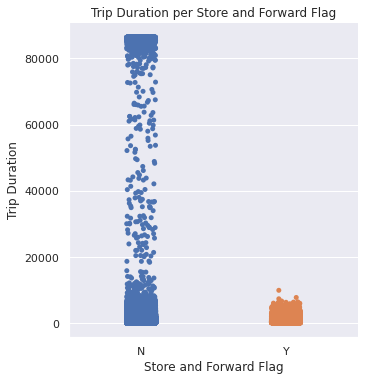

In [50]:
plt.figure(figsize=(8,5))
sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=df,kind='strip')
plt.title("Trip Duration per Store and Forward Flag")
plt.ylabel("Trip Duration")
plt.xlabel("Store and Forward Flag")
plt.show()

Trip duration is generally longer for trips whose flag was not stored.

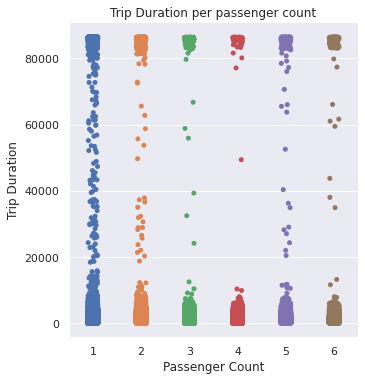

<Figure size 1080x720 with 0 Axes>

In [51]:
sns.catplot(y='trip_duration',x='passenger_count',data=df,kind='strip')
plt.xlabel('Passenger Count')
plt.ylabel('Trip Duration')
plt.title("Trip Duration per passenger count")
plt.figure(figsize=(15,10))
plt.show()

There is no visible relation between trip duration and passenger count

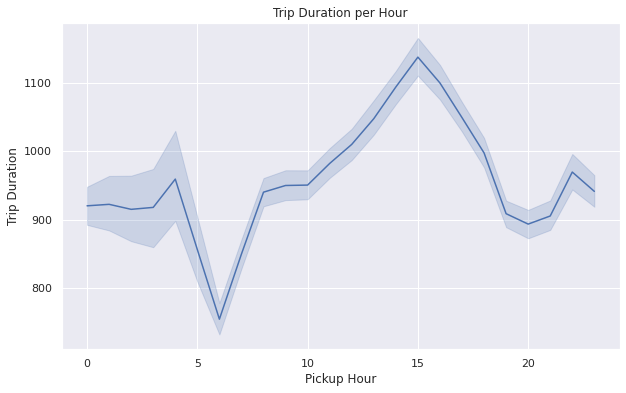

In [52]:
# trip duration per hour
figure,ax=plt.subplots(ncols=1,figsize=(10,6))
ax=sns.lineplot(x='pickup_hour',y='trip_duration',data=df)
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Duration')
plt.title("Trip Duration per Hour")
plt.show()

We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.
Trip duration is the lowest around 6 am as streets may not be busy

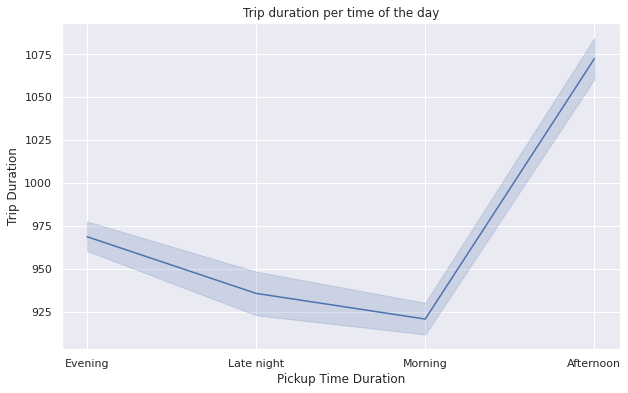

In [53]:
#trip duration per time of the day
figure,ax=plt.subplots(ncols=1,figsize=(10,6))
ax=sns.lineplot(x='pickup_timeof_day',y='trip_duration',data=df)
plt.xlabel('Pickup Time Duration')
plt.ylabel('Trip Duration')
plt.title("Trip duration per time of the day")
plt.show()

trip duration is maximum in the afternoon and the lowest between latre night and morning

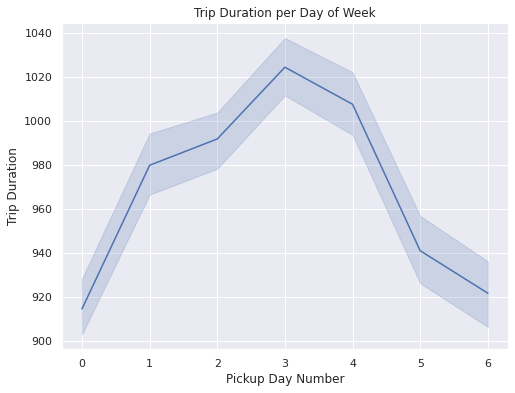

In [54]:
#trip duration per day of week
figure,ax=plt.subplots(ncols=1,figsize=(8,6))
ax=sns.lineplot(x='pickup_day_no',y='trip_duration',data=df)
plt.xlabel('Pickup Day Number')
plt.ylabel('Trip Duration')
plt.title("Trip Duration per Day of Week")
plt.show()

It is longest on thursday closely followed by fridays

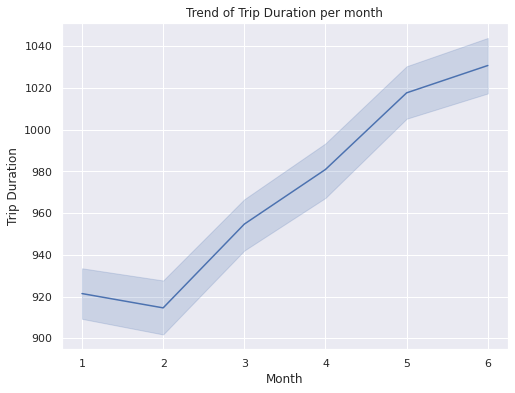

In [55]:
#trip duration per month
figure,ax=plt.subplots(ncols=1,figsize=(8,6))
ax=sns.lineplot(x='pickup_month',y='trip_duration',data=df)
plt.xlabel('Month')
plt.ylabel('Trip Duration')
plt.title("Trend of Trip Duration per month")
plt.show()

february trip duration rising every month

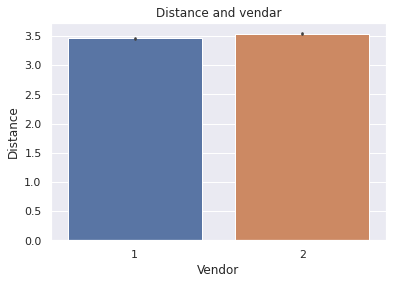

In [56]:
figure,ax=plt.subplots(ncols=1)
ax=sns.barplot(x='vendor_id',y='distance',data=df,estimator=np.mean)
plt.xlabel('Vendor')
plt.ylabel('Distance')
plt.title("Distance and vendar")
plt.show()

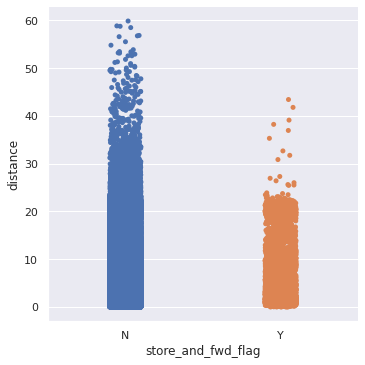

In [57]:
sns.catplot(y='distance',x='store_and_fwd_flag',data=df,kind="strip")

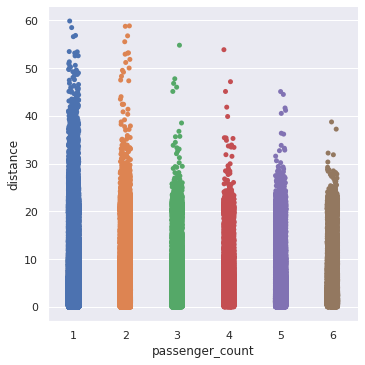

In [58]:
sns.catplot(y='distance',x='passenger_count',data=df,kind="strip")

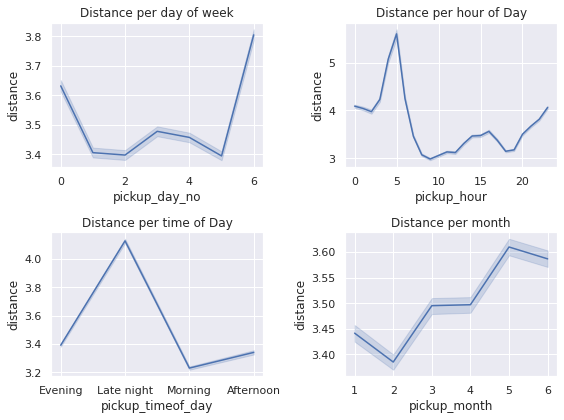

In [59]:
figure, axis=plt.subplots(nrows=2,ncols=2,figsize=(8,6))
axis[0,0].set_title('Distance per day of week')
axis[0,0]=sns.lineplot(x="pickup_day_no",y='distance',data=df,ax=axis[0,0])

axis[0,1].set_title('Distance per hour of Day')
axis[0,1]=sns.lineplot(x="pickup_hour",y='distance',data=df,ax=axis[0,1])

axis[1,0].set_title("Distance per time of Day")
axis[1,0]=sns.lineplot(x=df['pickup_timeof_day'],y="distance",data=df,ax=axis[1,0])

axis[1,1].set_title("Distance per month")
axis[1,1]=sns.lineplot(x="pickup_month",y="distance",data=df,ax=axis[1,1])

plt.tight_layout()

1. Distances are longer on Sundays probably because it’s weekend.
Monday trip distances are also quite high.
This probably means that there can be outstation trips on these days and/or the streets are busier.
2. Distances are the longest around 5 am.
3. As seen above also, distances being the longest during late night or it maybe called as early morning too.
This can probably point to outstation trips where people start early for the day.
4. similarly trip distance is the lowest in February and the maximum in May.

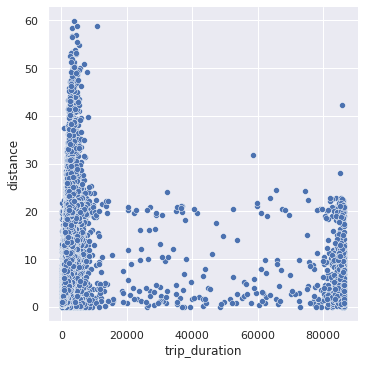

In [60]:
#trip duration and distance
sns.relplot(y='distance',x='trip_duration',data=df)

we can see there are trip which trip duration as short as 0 second and yet covering a large distance and trips with 0 km distance and long trip duration

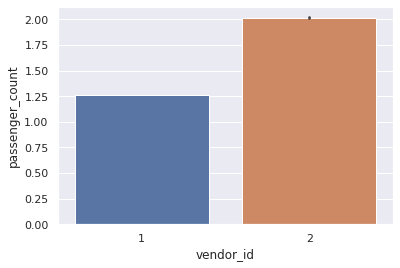

In [61]:
#passenger count and vendor id
sns.barplot(y='passenger_count',x='vendor_id',data=df)

In [62]:
df.head()

id  vendor_id  ... dropoff_timeof_day  distance
0  id2875421          2  ...            Evening  1.498523
1  id2377394          1  ...         Late night  1.805510
2  id3858529          2  ...          Afternoon  6.385108
3  id3504673          2  ...            Evening  1.485501
4  id2181028          2  ...          Afternoon  1.188590

[5 rows x 22 columns]

In [63]:
df.shape

(1426289, 22)

1. fix min and max latitude

lat-- 40.730610
   long ---73.935242

In [64]:
df = df.loc[df['pickup_latitude'].between(40,42)]
df = df.loc[df['pickup_longitude'].between(-75,-72)]
df = df.loc[df['dropoff_latitude'].between(40,42)]
df = df.loc[df['dropoff_longitude'].between(-75,-72)]

In [65]:
df.head()

id  vendor_id  ... dropoff_timeof_day  distance
0  id2875421          2  ...            Evening  1.498523
1  id2377394          1  ...         Late night  1.805510
2  id3858529          2  ...          Afternoon  6.385108
3  id3504673          2  ...            Evening  1.485501
4  id2181028          2  ...          Afternoon  1.188590

[5 rows x 22 columns]

In [66]:
#Replacing Yes/No values with 1 and 0
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({"Y":1,"N":0}).astype(int)

In [67]:


dummy = pd.get_dummies(df.vendor_id, prefix='vendor_id')
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.pickup_month, prefix='pickup_month')
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.pickup_day_no, prefix='pickup_day_no')
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.pickup_hour, prefix='pickup_hour')
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.passenger_count, prefix='passenger_count')
df = pd.concat([df,dummy], axis = 1)

In [68]:
df.head()

id  vendor_id  ... passenger_count_5 passenger_count_6
0  id2875421          2  ...                 0                 0
1  id2377394          1  ...                 0                 0
2  id3858529          2  ...                 0                 0
3  id3504673          2  ...                 0                 0
4  id2181028          2  ...                 0                 0

[5 rows x 67 columns]

In [ ]:
###Now i have extracted the information from the below features variable and now we don't need them for further analysis


In [71]:
df = df.drop(columns=['pickup_day','pickup_timeof_day','dropoff_day','pickup_month','dropoff_timeof_day','pickup_day_no','dropoff_day_no','pickup_hour','store_and_fwd_flag','passenger_count',
'dropoff_month','dropoff_hour','id','pickup_datetime','dropoff_datetime','vendor_id'])

In [72]:
df.shape

(1426285, 51)

In [73]:
#Calculate Speed in km/h for further insights
df['speed'] = (df.distance/(df.trip_duration/3600))

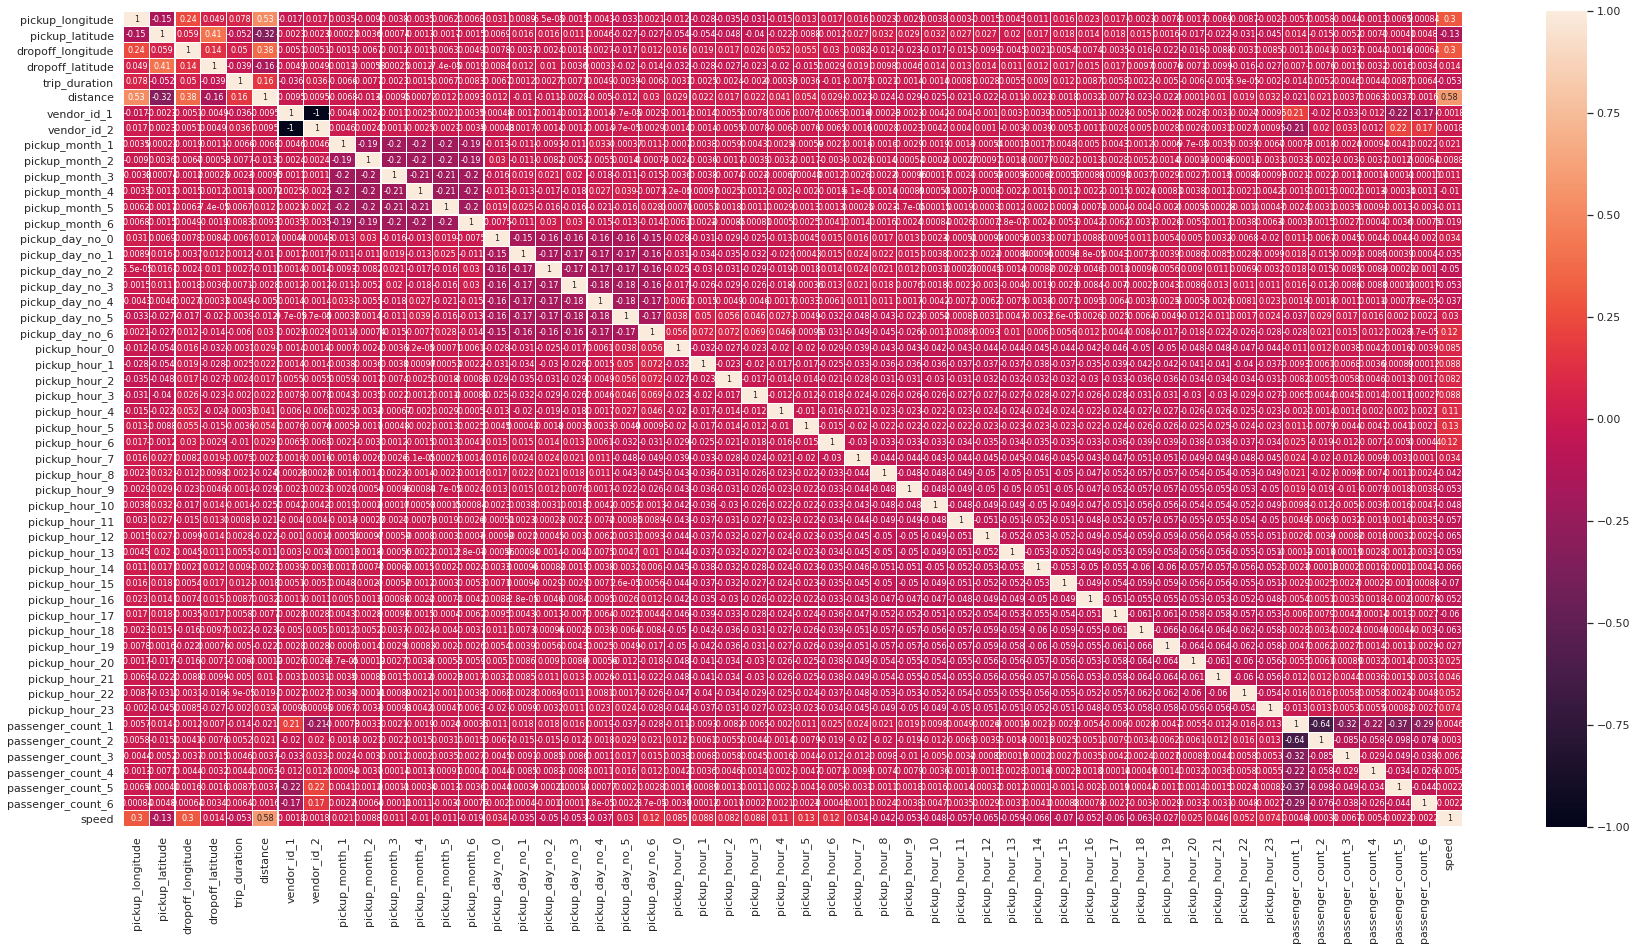

In [79]:
corrmat = df.corr()
  
f, ax = plt.subplots(figsize =(30, 15))
sns.heatmap(corrmat, ax = ax, annot=True, annot_kws= {"size":8}, linewidths = 0.1)

We can see that some of the feature variables have a high correlation among them. Therefore we have to take care of that. We can see clearly that the target variable 'trip duration' is not highly linearly related to the features variable.


In [80]:
#TArget and independent variable
y = np.log(df['trip_duration'])
x=df.drop(columns=['trip_duration'])

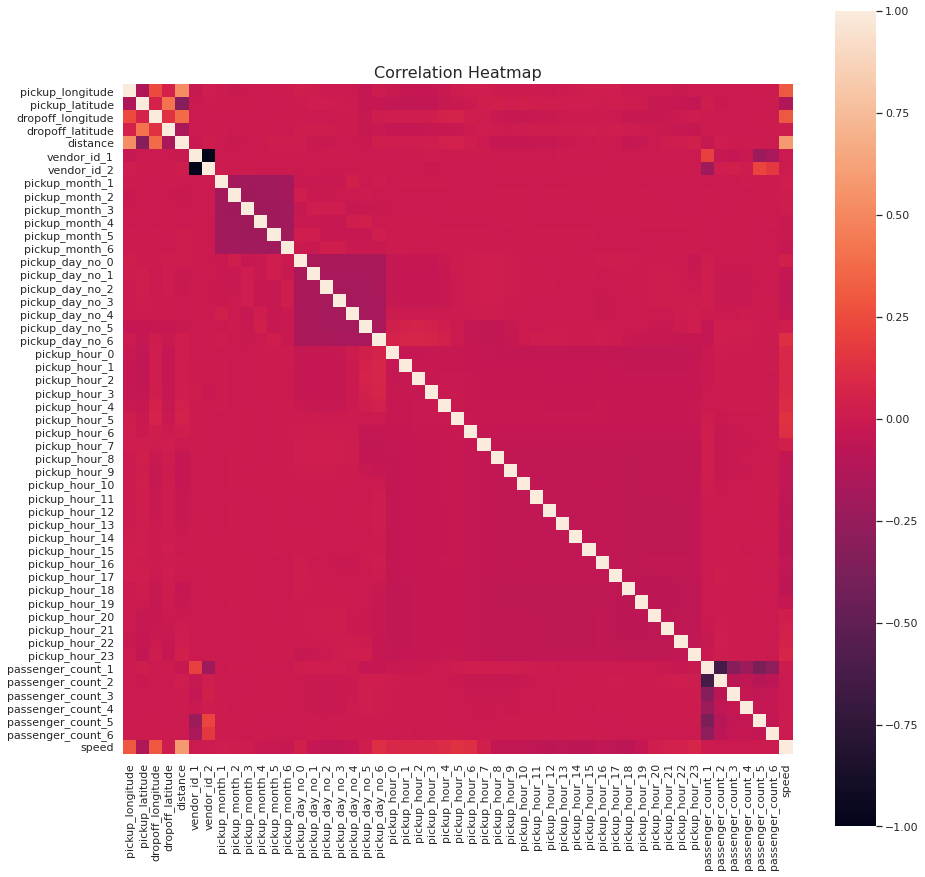

In [81]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(x).corr()
corr.index = pd.DataFrame(x).columns
sns.heatmap(corr,  vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [91]:
#model building
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.2, random_state=50)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1141028, 51) (1141028,)
(285257, 51) (285257,)


In [86]:
#linear Regression
std = StandardScaler()
X_train_std = std.fit_transform(x_train)
X_test_std = std.transform(x_test)

In [92]:
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [94]:
reg = LinearRegression().fit(x_train, y_train)

In [95]:
reg.score(x_train, y_train)

0.6620127305275175

In [96]:
y_pred_train = reg.predict(x_train)

In [97]:
y_pred_test = reg.predict(x_test)

In [98]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 0.17568634746366737
RMSE : 0.4191495526225304
R2 : 0.6620127305275175
Adjusted R2 :  0.6619976229785918


In [99]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 0.17533859985226172
RMSE : 0.4187345219256011
R2 : 0.6633616046534454
Adjusted R2 :  0.6633014073982687


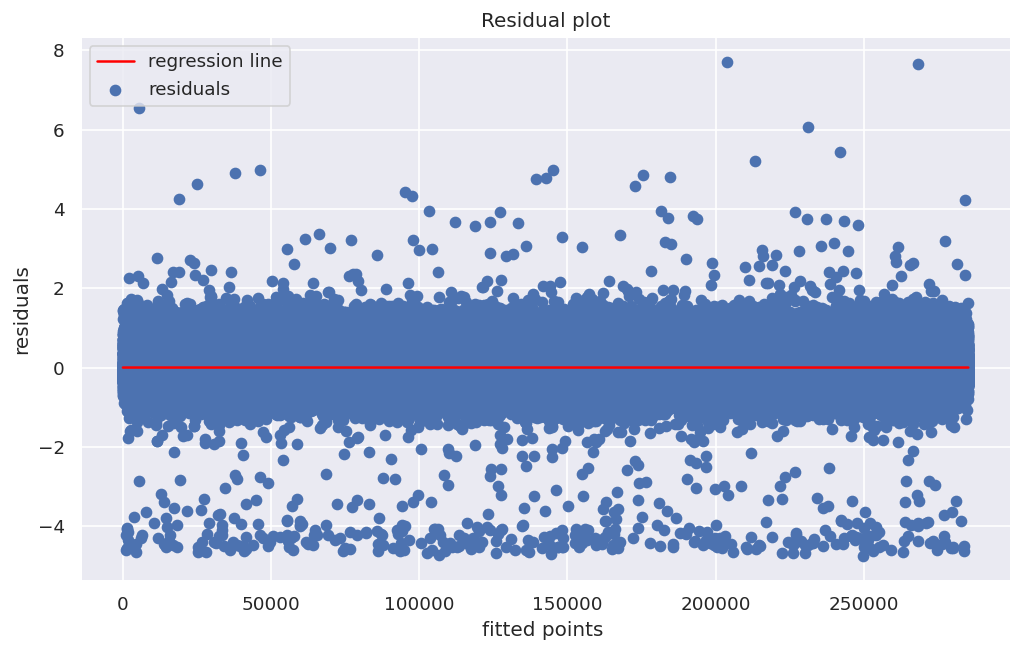

In [100]:
#Heteroskedasticity
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

In [ ]:
df['passenger_count'].value_counts().reset_index()

index  passenger_count
0      1          1033540
1      2           210318
2      5            78088
3      3            59896
4      6            48333
5      4            28404
6      0               60
7      7                3
8      9                1
9      8                1

In [ ]:
df[df['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64

In [ ]:
df=df[df['passenger_count']!=0]

In [ ]:
df["pickup_datetime"][0]

'2016-03-14 17:24:55'

In [ ]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])
df.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

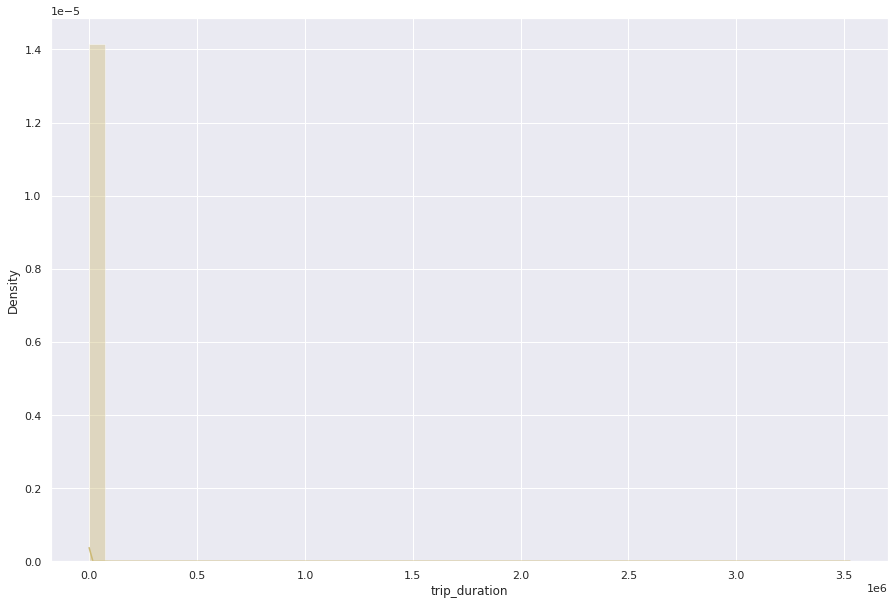

In [ ]:
# Dependent variable 'trip_duration'
plt.figure(figsize=(15,10))
sns.distplot(df['trip_duration'],color="y")

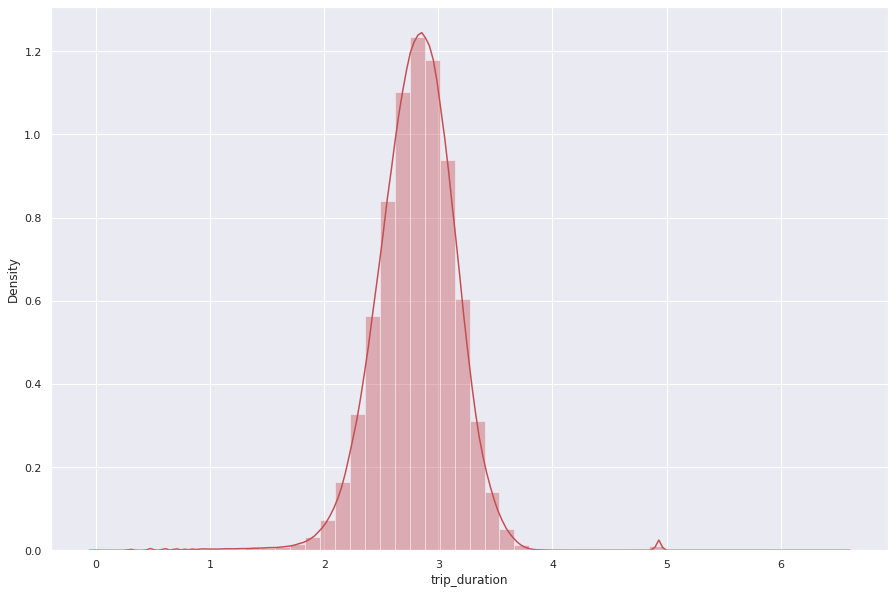

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(np.log10(df['trip_duration']),color="R")

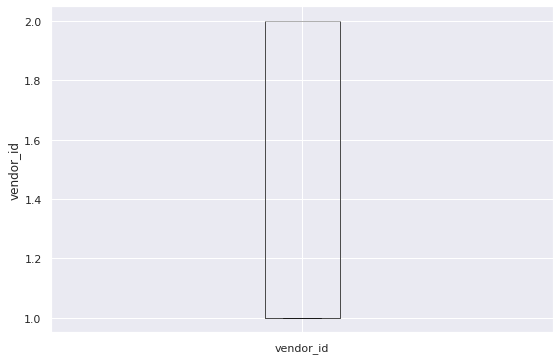

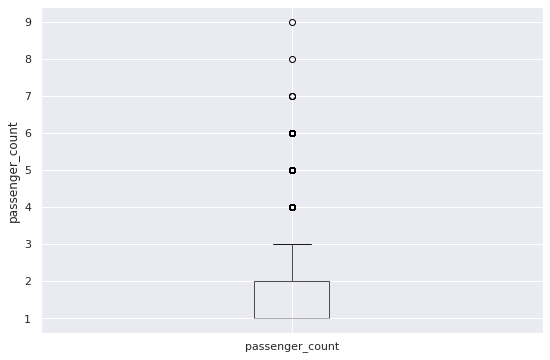

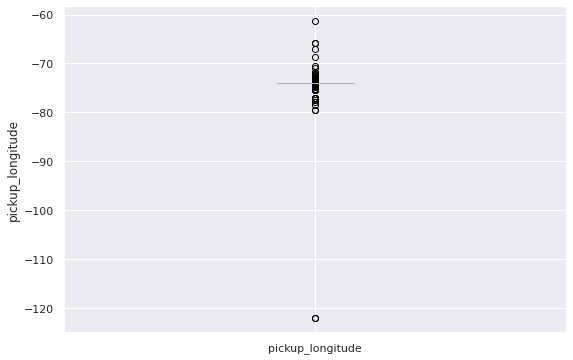

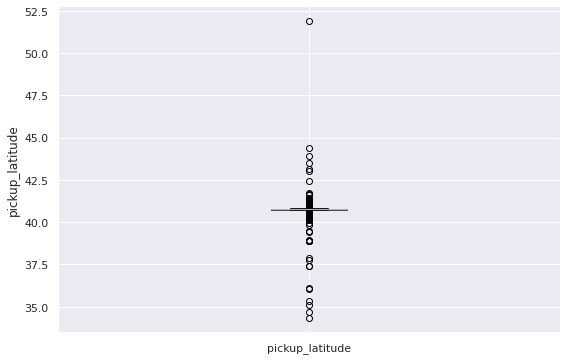

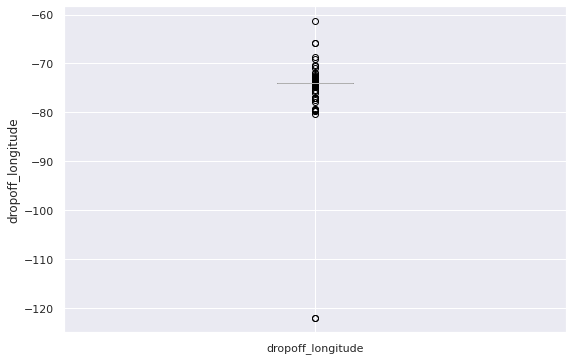

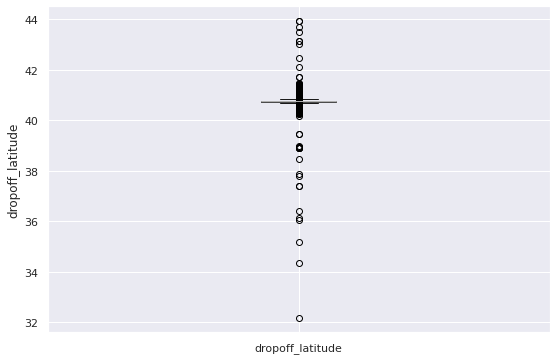

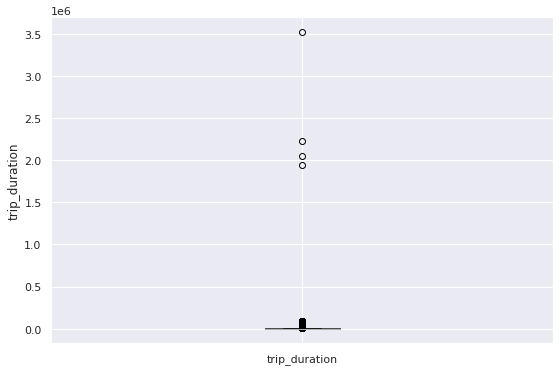

In [ ]:
# plot a boxplot for the label by each numerical feature  
for col in df.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  df.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Okay so what we know now :

Vendor ID has no outlier.
In passenger count 4 and more passengers are being treated as outliers.
pickup_longitude and pickup_latitude has outliers as well.
dropoff_longitude and dropoff_latitude has outliers too.
Our target variable trip_duration has alot of outliers
Now it's time for our white blood cells to get in action and remove these outliers. So our Outlier treatment will be using IQR(inter-quartile range) method

In [ ]:
numeric_features = df.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

Let's also plot a bar plot of all the features we have. We will also plot the mean and median to see how normally distributed our features are.

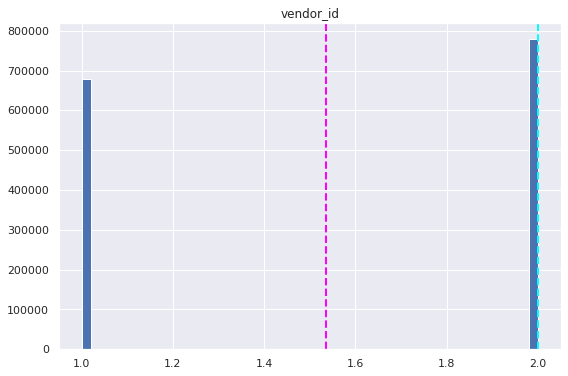

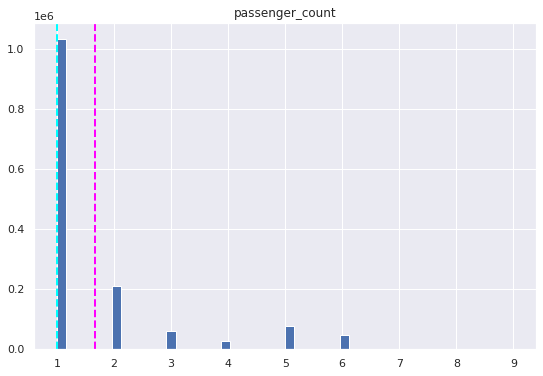

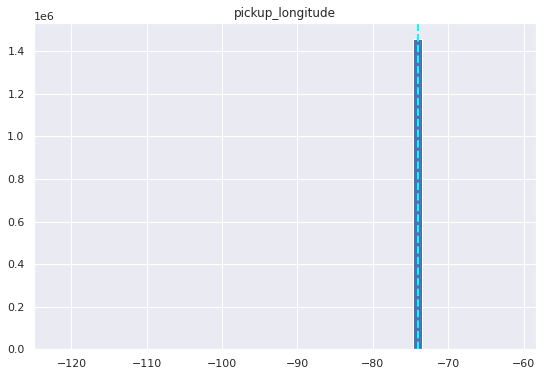

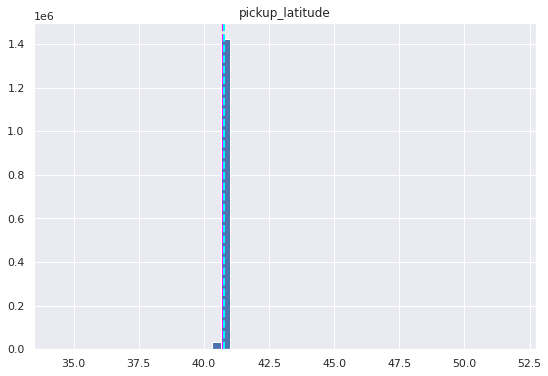

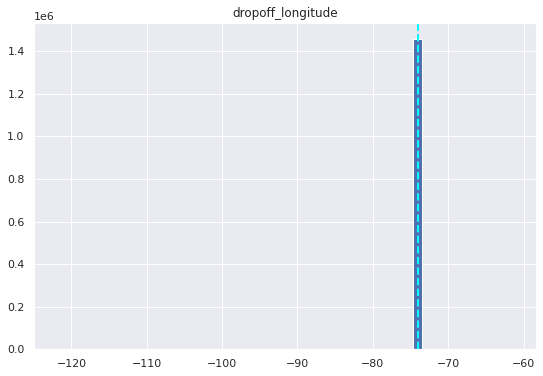

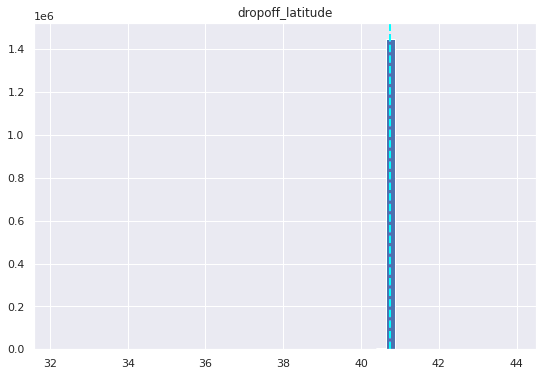

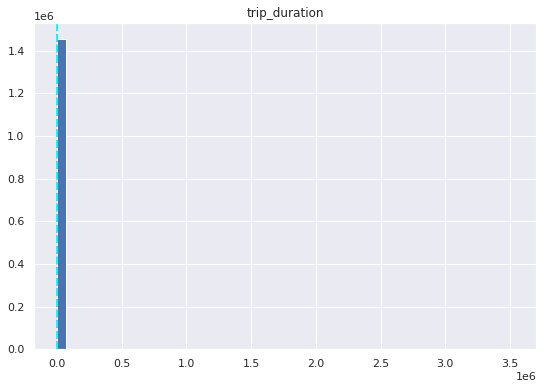

In [ ]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

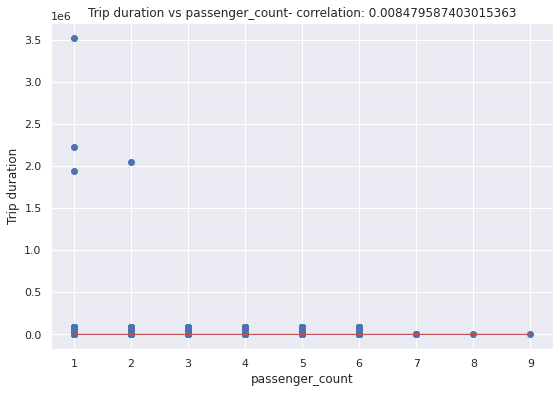

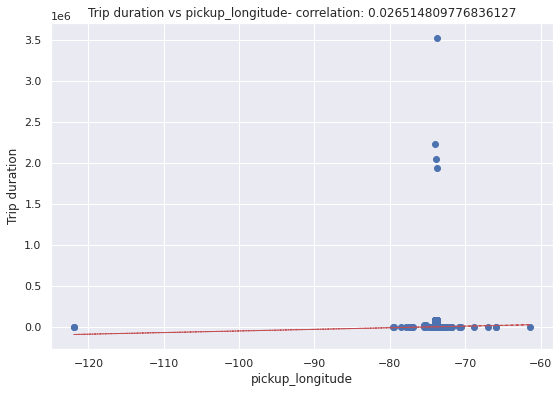

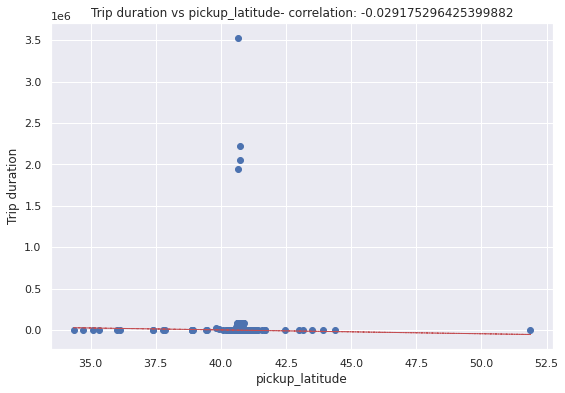

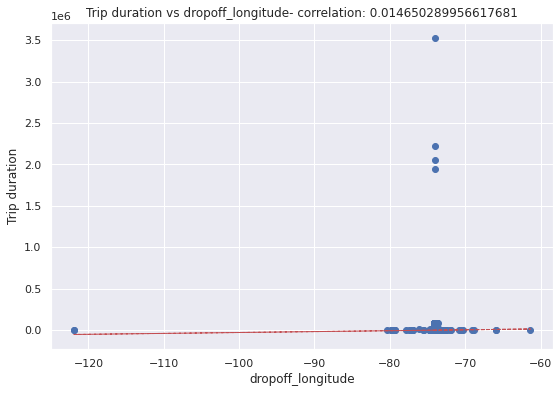

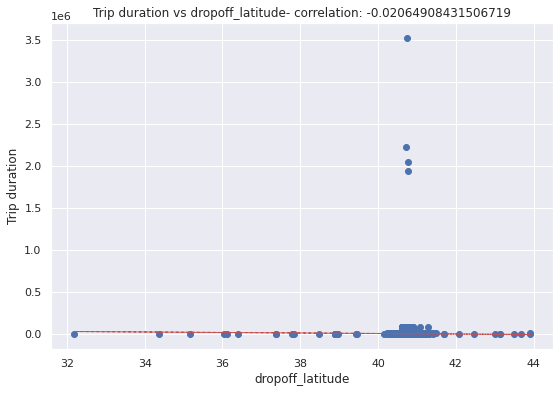

In [ ]:
for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip duration')
    ax.set_title('Trip duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(df[col], df['trip_duration'], 1)
    y_hat = np.poly1d(z)(df[col])

    plt.plot(df[col], y_hat, "r--", lw=1)

plt.show()


We were working on a dataset with taxi don't forget that we all kow sometimes when we start thinking too deply we tend to forget what we were doing so let's work with latitude and longitude which we have.

Here we will plot a scatter plot of pickup and dropoff locations.

Text(0.5, 1.0, 'Dropoff')

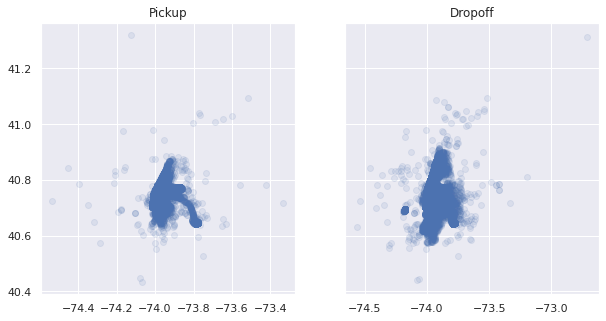

In [ ]:
#plot to see the differences - minimal, but there is some change
n = 100000 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            alpha = 0.1)
ax1.set_title('Pickup')
ax2.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            alpha = 0.1)
ax2.set_title('Dropoff')

Let us try to atleast see what places were booked the most using our political and geographical maps. We know everyone loves maps so let's

As we have converted our date time column into manipulative form now let's make use of it to explore the data and let it help the model run better.

We will make new columns for days of the week of their corresponging pickup and drop-off day

In [ ]:

df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df.head()


id  vendor_id  ... pickup_day dropoff_day
0  id2875421          2  ...     Monday      Monday
1  id2377394          1  ...     Sunday      Sunday
2  id3858529          2  ...    Tuesday     Tuesday
3  id3504673          2  ...  Wednesday   Wednesday
4  id2181028          2  ...   Saturday    Saturday

[5 rows x 13 columns]

After this we will now let's try to visualise our data and see which day has been the busiest for our hard working taxi drivers

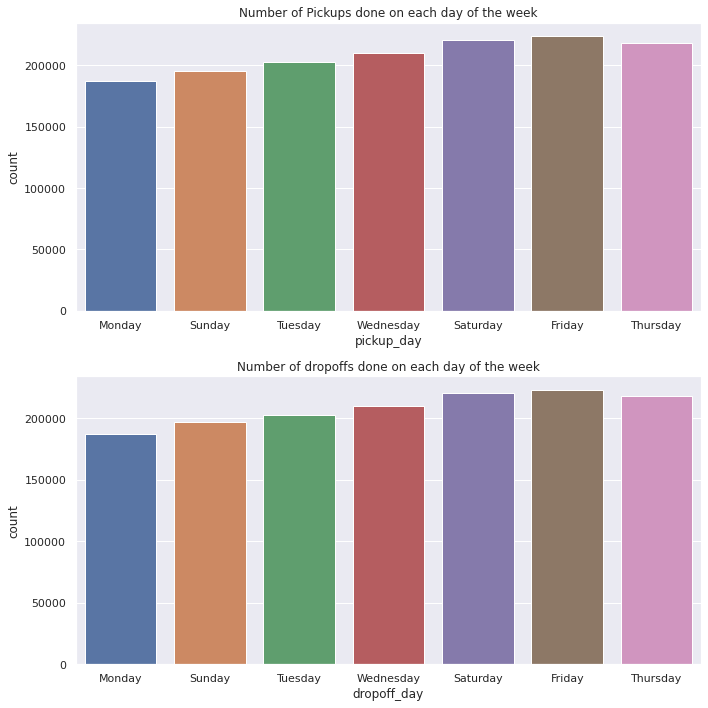

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.

Well it actually makes sense because most people will want to go out and enjoy their weekends partying and noone will have time to do that on a Monday. As everyone needs to earn the money back which was spent on Friday while parying.

Okay so as we have our days now let's also try to figure out the time and see what time was the busiest and what is least busiest.

The distribution of Pickup and Drop Off hours of the day

The time part is represented by hours,minutes and seconds which is difficult for the analysis thus we divide the times into 4 time zones:

Morning (4 hrs to 10 hrs)
Midday (10 hrs to 16 hrs)
Evening (16 hrs to 22 hrs)
Late night (22 hrs to 4 hrs)

In [ ]:
bins=np.array([0,1800,3600,5400,7200,90000])
df['duration_time']=pd.cut(df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [ ]:
import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
df['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

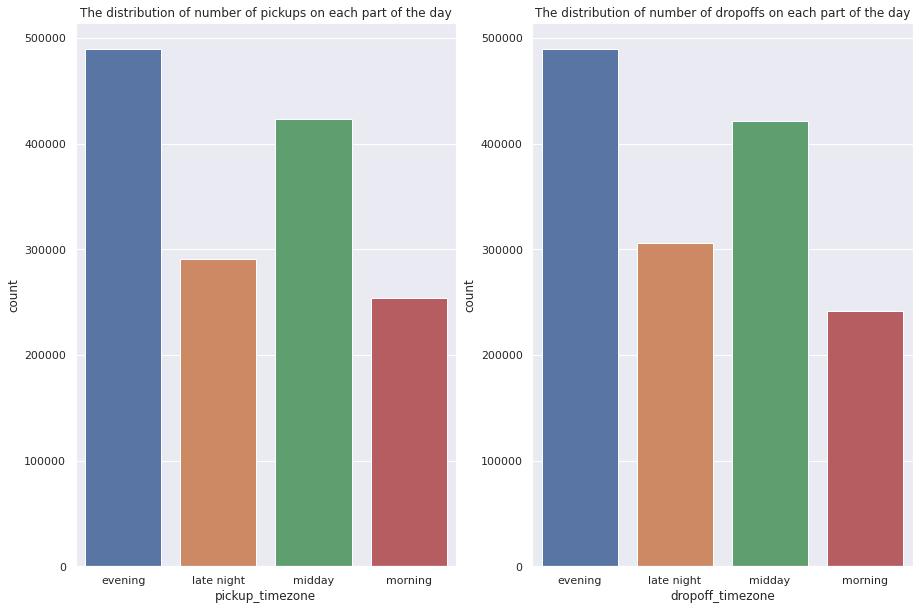

In [ ]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

So now we can see that our taxi's were booked in the evening most and midday following it while very less people travel in the morning as compared.

Text(0.5, 1.0, 'The Distribution of percentage of different duration of trips')

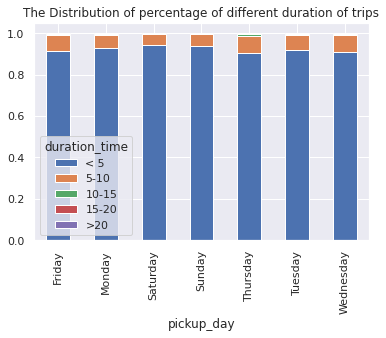

In [ ]:
ax1=df.groupby('pickup_day')['duration_time'].value_counts(normalize=True).unstack()
ax1.plot(kind='bar', stacked='True')
plt.title('The Distribution of percentage of different duration of trips')

Now we have worked enough on the time zones and days of the week now let's start working with a new varibale. So we know we have a longitude and latitude present so we will work on it to make a new feature that is distance.

So making a new distance column from the latitude and longitude

In [ ]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(lon_1, lon_2, lat_1, lat_2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(lon_1)
    lat2 = radians(lat_2)
    lon2 = radians(lon_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [ ]:
df["distance"] = df.apply(lambda x: get_distance(x["pickup_longitude"],x["dropoff_longitude"],x["pickup_latitude"],x["dropoff_latitude"]),axis=1)

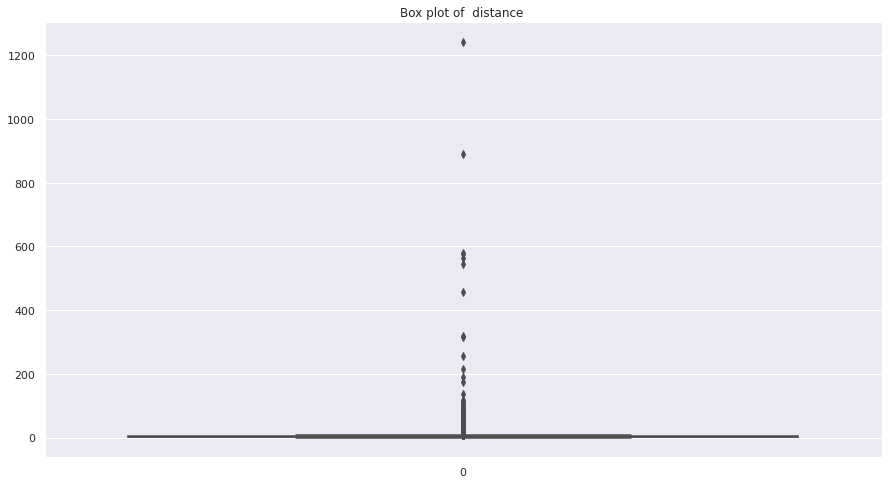

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=df['distance'], orient="v")

In [ ]:
percentile_q1 = np.percentile(df['distance'],25)
print(percentile_q1)
percentile_q2 = np.percentile(df['distance'],50)
print(percentile_q2)
percentile_q3 = np.percentile(df['distance'],75)
print(percentile_q3)

1.232295860862315
2.0944392378528622
3.8766616822922098


In [ ]:
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr

In [ ]:
print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.734252871282527
Upper limit for outlier  : 7.843210414437052


In [ ]:
df=df[df['distance']>lower_limit_outlier]
df=df[df['distance']<upper_limit_outlier]

In [ ]:
df.shape

(1317917, 17)

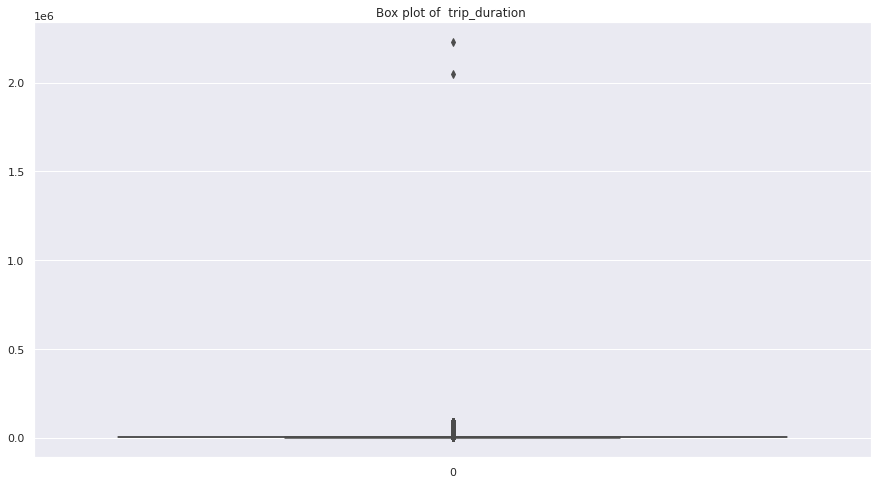

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=df['trip_duration'], orient="v")

In [ ]:
percentile_q1_trip_duration = np.percentile(df['trip_duration'],25)
print(percentile_q1_trip_duration)
percentile_q2_trip_duration = np.percentile(df['trip_duration'],50)
print(percentile_q2_trip_duration)
percentile_q3_trip_duration = np.percentile(df['trip_duration'],75)
print(percentile_q3_trip_duration)

373.0
605.0
931.0


In [ ]:
iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr

In [ ]:
print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

lower limit for outlier  : -464.0
Upper limit for outlier  : 1768.0


In [ ]:
df=df[df['trip_duration']>0]
df=df[df['trip_duration']<upper_limit_outlier_trip_duration]

In [ ]:
df.shape

(1277345, 17)

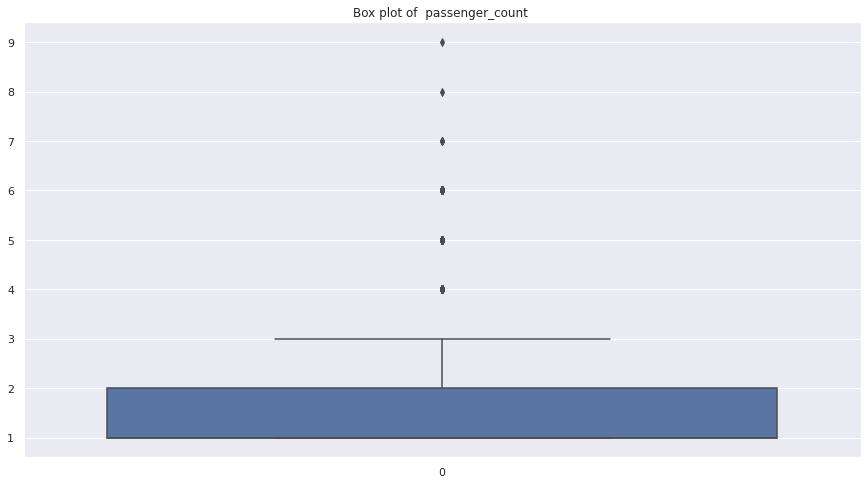

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=df['passenger_count'], orient="v")

In [ ]:
percentile_q1_passenger_count = np.percentile(df['passenger_count'],25)
print(percentile_q1_passenger_count)
percentile_q2_passenger_count = np.percentile(df['passenger_count'],50)
print(percentile_q2_passenger_count)
percentile_q3_passenger_count = np.percentile(df['passenger_count'],75)
print(percentile_q3_passenger_count)

1.0
1.0
2.0


In [ ]:
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr

In [ ]:
print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [ ]:
df=df[df['passenger_count']>0]
df=df[df['passenger_count']<upper_limit_outlier_passenger_count]

In [ ]:
df.shape

(1142605, 17)

In [ ]:
df.head()

id  vendor_id  ... dropoff_timezone  distance
0  id2875421          2  ...          evening  1.498991
1  id2377394          1  ...       late night  1.806074
3  id3504673          2  ...          evening  1.485965
4  id2181028          2  ...           midday  1.188962
7  id1324603          2  ...          morning  5.716775

[5 rows x 17 columns]

In [ ]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [ ]:
df['Day']=df['pickup_datetime'].dt.day_name()

In [ ]:
df["year"] = df["pickup_datetime"].apply(lambda x: x.year)
df["month"] = df["pickup_datetime"].apply(lambda x: x.month)
df["day_num"] = df["pickup_datetime"].apply(lambda x: x.day)
df["hour"] = df["pickup_datetime"].apply(lambda x: x.hour)
df["minute"] = df["pickup_datetime"].apply(lambda x: x.minute)

Finally let's start picking up the pace and do more feature engineering :

Converting trip duration into hours.
Taking log of our distance for normalisation of data.
Taking log of our trip duration as well to normalize it's data too.

In [ ]:
df['trip_duration_hour']=df['trip_duration']/3600
df['log_distance']=np.log(df.distance)
df['log_trip_duration']=np.log(df.trip_duration_hour)

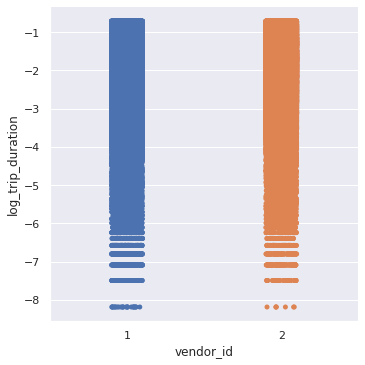

In [ ]:
sns.catplot(x="vendor_id", y="log_trip_duration",kind="strip",data=df)

Here we see that vendor 1 mostly provides short trip duration cabs while vendor 2 provides cab for both short and long trips

So now let's plot the relatioship of store_and_fwd_flag and our trip_duration

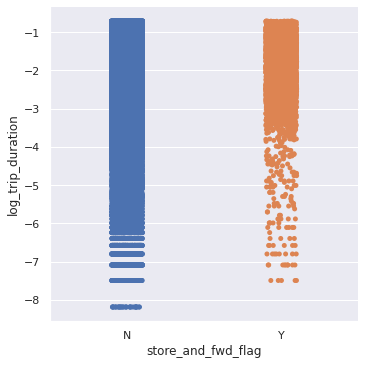

In [ ]:
sns.catplot(x="store_and_fwd_flag", y="log_trip_duration",kind="strip",data=df)

Now let's make some verses graph and plot the distance time graph

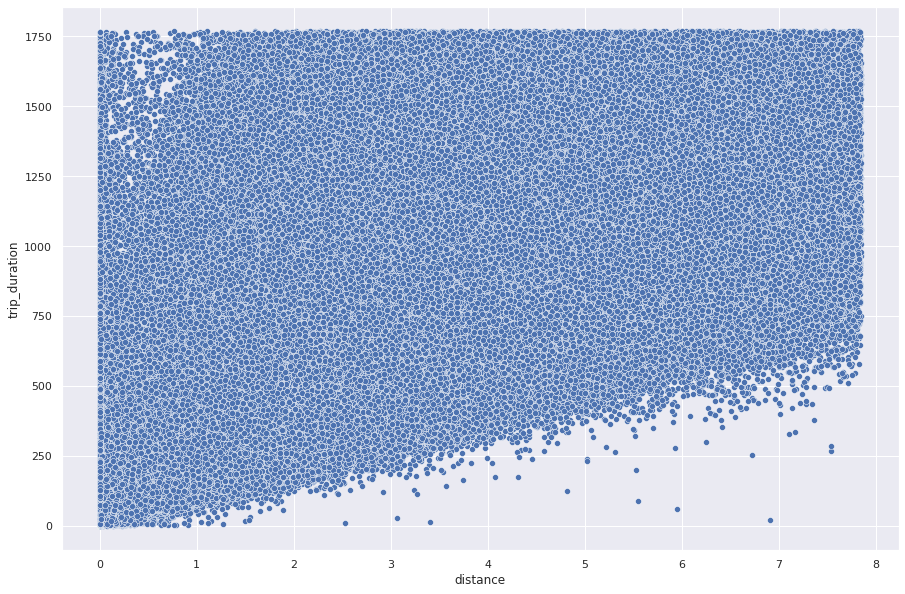

In [ ]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='distance',y='trip_duration',data=df)

Okay this seems a bit disappointing so let's use the normalized data instead and use log features we added earlier to have a normalized data graph of trip duration and distance

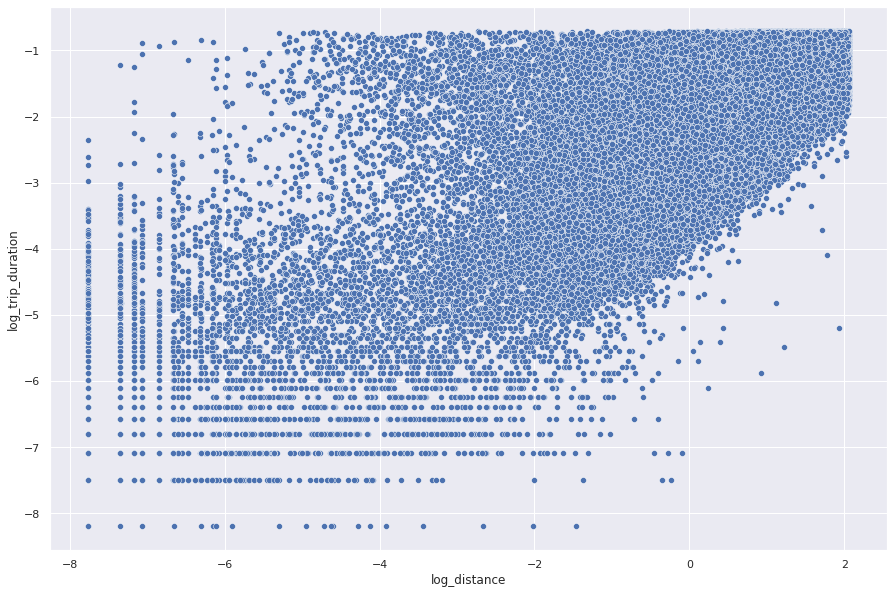

In [ ]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='log_distance',y='log_trip_duration',data=df)

Now we will see the difference between the original data and our normalized data

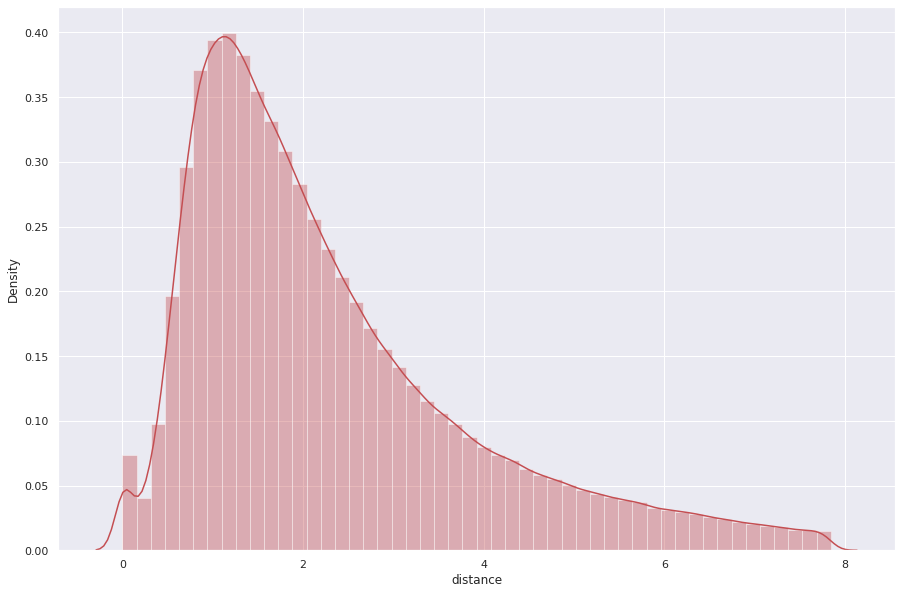

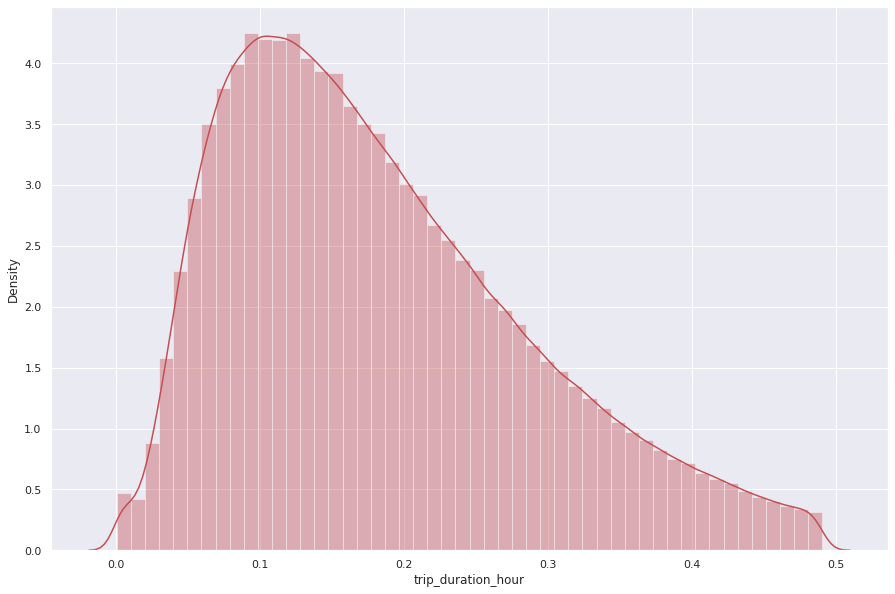

In [ ]:
sample=['distance','trip_duration_hour']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(df[i],color="R")

One Hot Encoding

In [ ]:
# One hot encoding
df= pd.get_dummies(df, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [ ]:
df.head()

id  vendor_id  ... Day_Tuesday Day_Wednesday
0  id2875421          2  ...           0             0
1  id2377394          1  ...           0             0
3  id3504673          2  ...           0             1
4  id2181028          2  ...           0             0
7  id1324603          2  ...           0             0

[5 rows x 33 columns]

In [ ]:
features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [ ]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_df=df[newdata]

In [ ]:
from scipy.stats import zscore
#Train test split
# numeric_cols = carprice.select_dtypes(include=[np.number]).columns
X = df[features].apply(zscore)[:100000]
y=df['trip_duration_hour'][:100000]

In [ ]:
X[:5]

vendor_id  passenger_count  ...  Day_Tuesday  Day_Wednesday
0   1.026271        -0.473673  ...    -0.402328      -0.409478
1  -0.974402        -0.473673  ...    -0.402328      -0.409478
3   1.026271        -0.473673  ...    -0.402328       2.442131
4   1.026271        -0.473673  ...    -0.402328      -0.409478
7   1.026271        -0.473673  ...    -0.402328      -0.409478

[5 rows x 19 columns]

Before Fitting data into our models lets split the into train and test dataset
It is a fast and easy procedure to perform, the results of which allows us to compare the performance of our taxi trip duration prediction for.

Although simple to use and interpret, there are times when the procedure should not be used, such as when you have a small dataset and situations where additional configuration is required but we definetly not have a small dataset.

In [ ]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)


Linear Regression
For linear regression we have some assumptions, given below are the basic assumptions that a linear regression model makes regarding a dataset on which it is applied:

Linear relationship: Relationship between response and feature variables should be linear. The linearity assumption can be tested using scatter plots.
Little or no multi-collinearity: It is assumed that there is little or no multicollinearity in the data. Multicollinearity occurs when the features (or independent variables) are not independent from each other.
Little or no auto-correlation: Another assumption is that there is little or no autocorrelation in the data. Autocorrelation occurs when the residual errors are not independent from each other.
Homoscedasticity: Homoscedasticity describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables and the dependent variable) is the same across all values of the independent v

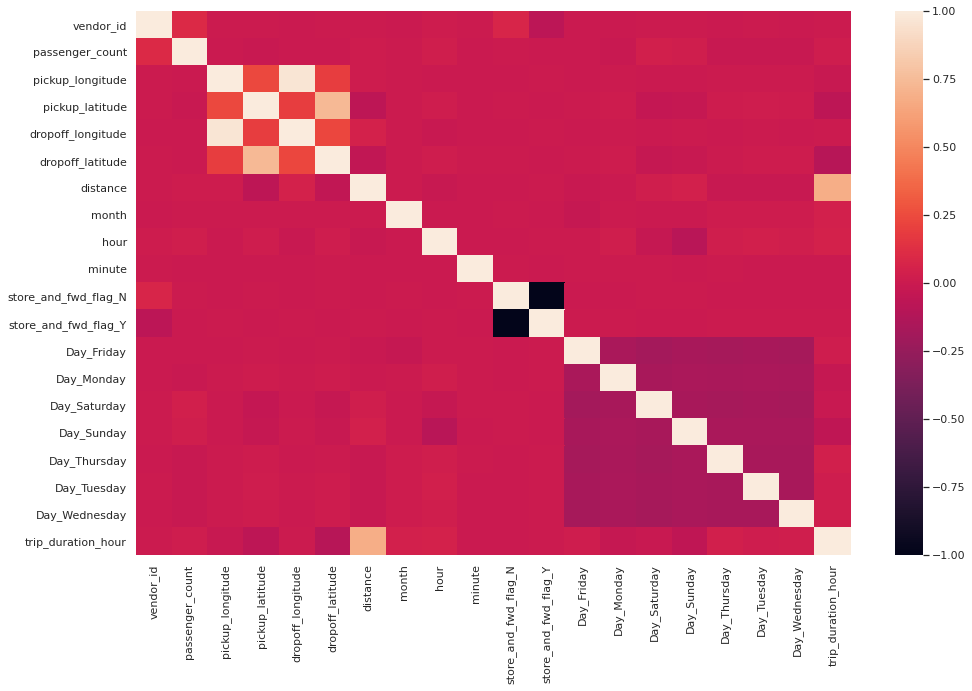

In [ ]:
plt.figure (figsize= (16,10))
sns.heatmap(trip_df.corr())

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
reg.score(X_train, y_train)

0.4977717521753691

In [ ]:
y_pred_train = reg.predict(X_train)

In [ ]:
y_pred_test = reg.predict(X_test)

In [ ]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 0.005544800863815122
RMSE : 0.07446341963551716
R2 : 0.49777175217536906
Adjusted R2 :  0.4976524431392517


In [ ]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 0.0054712642758744994
RMSE : 0.07396799494291095
R2 : 0.49593024351436577
Adjusted R2 :  0.4954508979000902


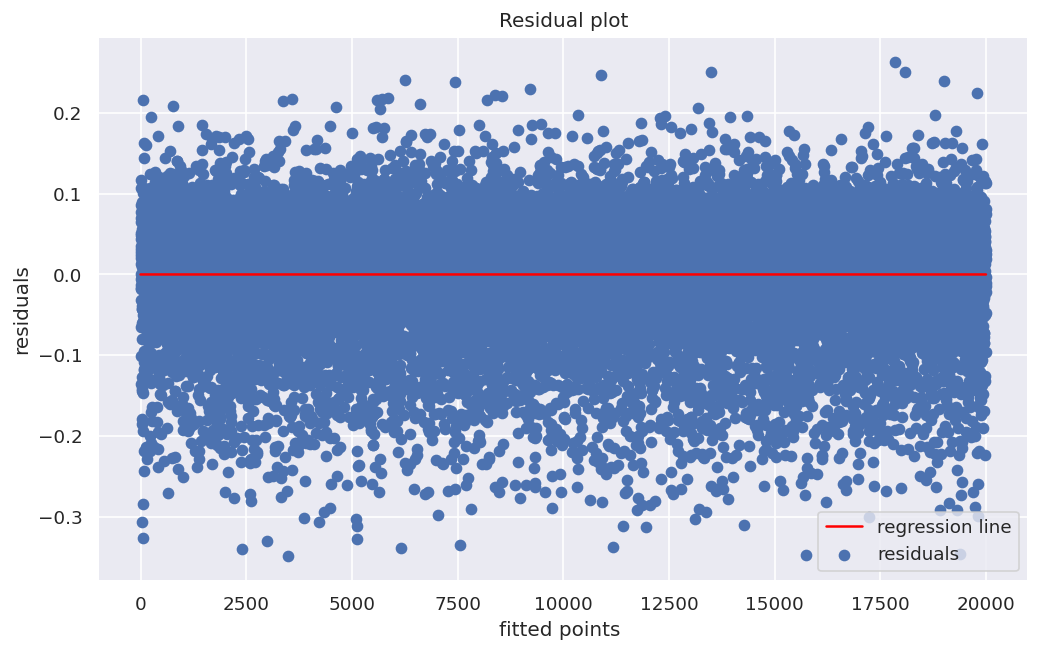

In [ ]:
#Heteroskedasticity
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

In [ ]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,16,20]

# HYperparameter Grid
param_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 16, 20],
                         'min_samples_split

In [ ]:
dt_grid.best_score_

0.6085952058609337

In [ ]:
dt_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
dt_optimal_model =dt_grid.best_estimator_

In [ ]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

In [ ]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

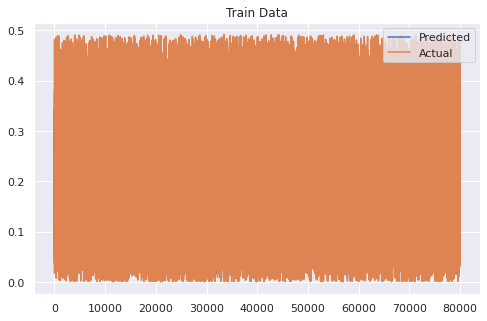

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_dt_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.003933693284929908
Train RMSE : 0.0627191620234989
Train R2 : 0.6437001193563989
Train Adjusted R2 :  0.6436154769741506


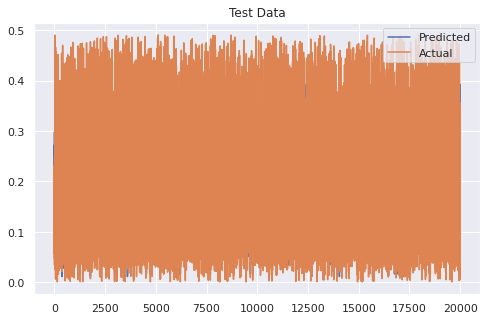

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_dt_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.004235598377226902
Test RMSE : 0.0650814749158845
Test R2 : 0.609772634819681
Test Adjusted R2 :  0.6094015477356758


In [ ]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:
dt_optimal_model.feature_importances_

array([9.38968142e-04, 4.43967868e-05, 9.14398484e-03, 4.46198246e-03,
       1.10728367e-02, 5.24065431e-02, 7.95299356e-01, 1.13750226e-03,
       9.12148562e-02, 1.38090212e-03, 0.00000000e+00, 0.00000000e+00,
       1.15545919e-03, 1.85697790e-03, 1.27165769e-02, 1.60198960e-02,
       7.31804693e-04, 1.33113813e-04, 2.84843170e-04])

In [ ]:
importances = dt_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
importance_df

Feature  Feature Importance
0              vendor_id                0.00
1        passenger_count                0.00
2       pickup_longitude                0.01
3        pickup_latitude                0.00
4      dropoff_longitude                0.01
5       dropoff_latitude                0.05
6               distance                0.80
7                  month                0.00
8                   hour                0.09
9                 minute                0.00
10  store_and_fwd_flag_N                0.00
11  store_and_fwd_flag_Y                0.00
12            Day_Friday                0.00
13            Day_Monday                0.00
14          Day_Saturday                0.01
15            Day_Sunday                0.02
16          Day_Thursday                0.00
17           Day_Tuesday                0.00
18         Day_Wednesday                0.00

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
6               distance                0.80
8                   hour                0.09
5       dropoff_latitude                0.05
15            Day_Sunday                0.02
2       pickup_longitude                0.01
4      dropoff_longitude                0.01
14          Day_Saturday                0.01
0              vendor_id                0.00
12            Day_Friday                0.00
17           Day_Tuesday                0.00
16          Day_Thursday                0.00
13            Day_Monday                0.00
9                 minute                0.00
11  store_and_fwd_flag_Y                0.00
10  store_and_fwd_flag_N                0.00
1        passenger_count                0.00
7                  month                0.00
3        pickup_latitude                0.00
18         Day_Wednesday                0.00

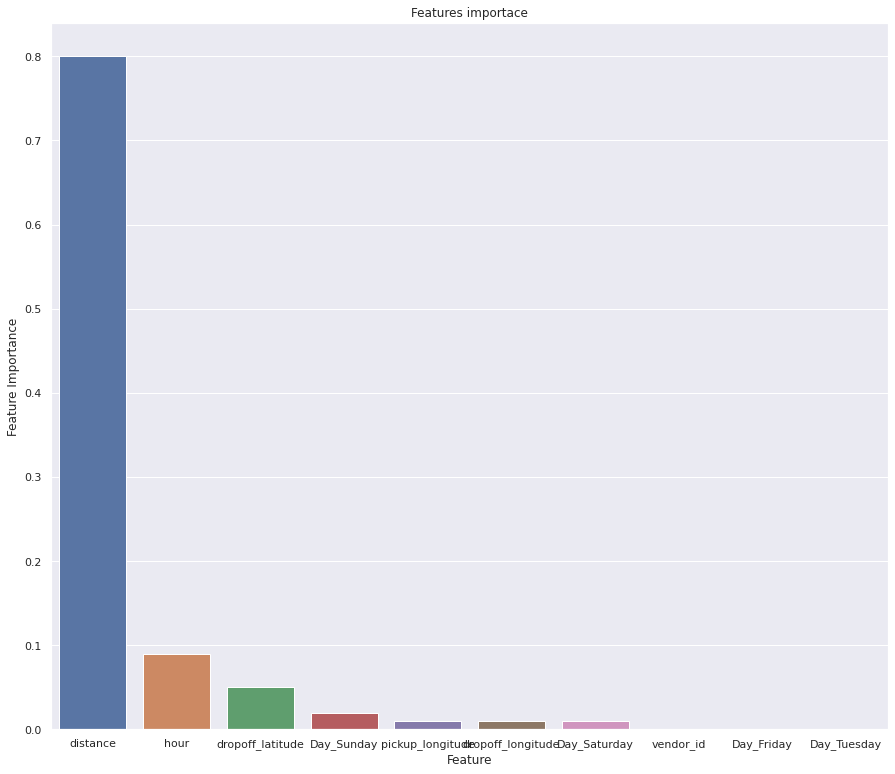

In [ ]:
plt.figure(figsize=(15,13))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

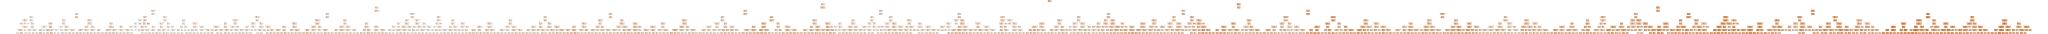

In [ ]:
graph = Source(tree.export_graphviz(dt_optimal_model, out_file=None,feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

Applying Lasso Regression to our DataSet

In [ ]:
from sklearn.model_selection import GridSearchCV
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
lasso_regressor.score(X_train, y_train)

0.4977738411443353